# Brain-to-Text '25: Comprehensive Exploratory Data Analysis (EDA)

This merged notebook combines insights from previous analyses to provide a complete guide to the Brain-to-Text 2025 Competition dataset. It serves as a bridge between the raw neural data and the design of high-performance models (Transformers, Neural LMs).

## Objectives
1.  **Data Fundamentals**: Understand the HDF5 structure and the 512 neural features.
2.  **Signal Visualization**: Visualize electrode activity to inform preprocessing (Z-scoring, binning).
3.  **Linguistic Patterns**: Analyze key target patterns (phoneme distributions, N-grams) for the Language Model.
4.  **Architectural Setup**: Use metrics like sequence length and feature redundancy to size your Transformer model.
5.  **Signal Integrity**: Assess long-term stability to prepare for data drift.

## 1. Setup and Data Access

We start by importing necessary libraries and defining the path to the dataset. Understanding where the data lives is the first step.

Analyzing signal stability across ALL 45 sessions...


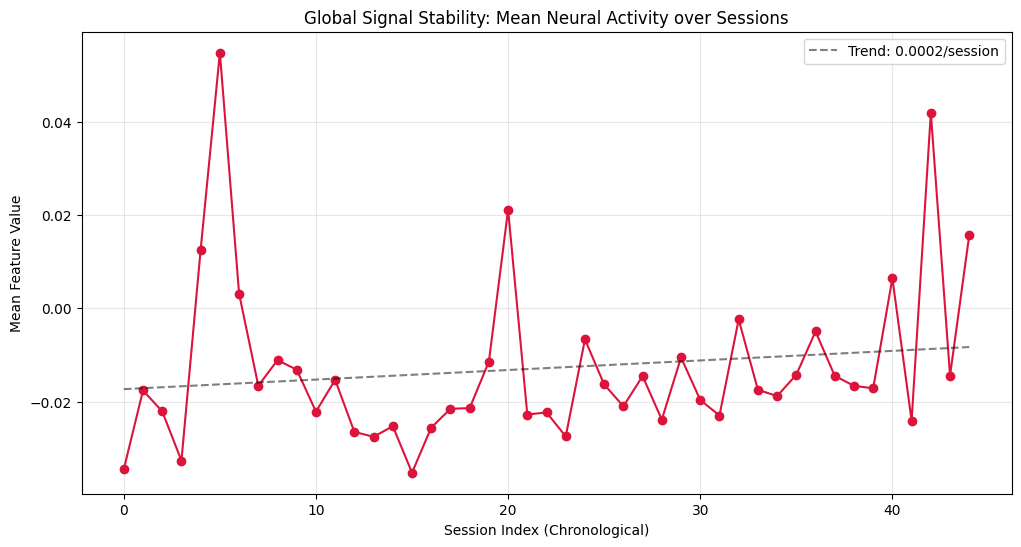

Start Mean: -0.0345 -> End Mean: 0.0157


In [20]:

session_means = []
days = []

print(f"Analyzing signal stability across ALL {len(sessions)} sessions...")

for i, sess in enumerate(sessions):
    path = os.path.join(DATA_DIR, sess, 'data_train.hdf5')
    if os.path.exists(path):
        with h5py.File(path, 'r') as f:
            # Calculate mean feature value for a few trials in this session
            # to estimate "Mean Neural Population Activity" for that day.
            
            # Sample 5 random trials to get a robust mean for the session
            keys = list(f.keys())
            if not keys: continue
            
            sampled_keys = keys[:5] 
            sess_vals = []
            
            for k in sampled_keys:
                # features: Time x Channels. Mean over both.
                # Just mean of absolute values? Or raw? 
                # Features are likely crossings/power (positive).
                feat = f[k]['input_features'][:]
                sess_vals.append(np.mean(feat))
            
            if sess_vals:
                session_means.append(np.mean(sess_vals))
                days.append(i) # Assuming sessions are sorted chronologically

if session_means:
    plt.figure(figsize=(12, 6))
    plt.plot(days, session_means, marker='o', linestyle='-', color='crimson')
    plt.title("Global Signal Stability: Mean Neural Activity over Sessions")
    plt.xlabel("Session Index (Chronological)")
    plt.ylabel("Mean Feature Value")
    plt.grid(True, alpha=0.3)
    
    # Trend line
    z = np.polyfit(days, session_means, 1)
    p = np.poly1d(z)
    plt.plot(days, p(days), "k--", alpha=0.5, label=f"Trend: {z[0]:.4f}/session")
    plt.legend()
    plt.show()
    
    print(f"Start Mean: {session_means[0]:.4f} -> End Mean: {session_means[-1]:.4f}")
else:
    print("No stability data found.")


### 💡 Why this analysis?
**Objective**: To confirm the environment is set up correctly.
**Output Interpretation**: If "Found X sessions" is printed, you are ready to proceed. If "WARNING" appears, you cannot run any subsequent code. Fix your paths first!

## 2. Dataset Overview: HDF5 Structure

The data is stored in HDF5 files, optimized for large arrays. We need to look inside one trial to understand the input dimensions.

In [21]:
def load_sample_trial(session_idx=0, trial_idx=0):
    if not sessions: return None, None, None
    session_path = os.path.join(DATA_DIR, sessions[session_idx], "data_train.hdf5")
    with h5py.File(session_path, "r") as f:
        # Access the first trial in the sorted list of keys
        trial_key = sorted(list(f.keys()))[trial_idx]
        group = f[trial_key]
        # Extract main data arrays
        features = group['input_features'][:]  # Neural data
        phonemes = group['seq_class_ids'][:]   # Target labels
        return features, phonemes, trial_key

features, phonemes, trial_key = load_sample_trial()

if features is not None:
    print(f"Trial Key: {trial_key}")
    print(f"Neural Features Shape: {features.shape} (Timebins x Channels)")
    print(f"Target Phonemes Length: {len(phonemes)}")
    print(f"Sample Features (first 5 bins, first 5 channels):\n{features[:5, :5]}")

Trial Key: trial_0000
Neural Features Shape: (321, 512) (Timebins x Channels)
Target Phonemes Length: 500
Sample Features (first 5 bins, first 5 channels):
[[ 2.3076649  -0.78699756 -0.64687246 -0.5465877   0.25500455]
 [-0.5859305  -0.78699756 -0.64687246 -0.5465877  -0.83641505]
 [-0.5859305  -0.78699756 -0.64687246 -0.5465877  -0.83641505]
 [ 0.8608672   1.2421287  -0.64687246 -0.5465877  -0.83641505]
 [-0.5859305  -0.78699756 -0.64687246 -0.5465877  -0.83641505]]


### 💡 Why this analysis?
**Objective**: To verify the shape of your input tensors.
**Output Interpretation**:
*   **Features Shape (T, 512)**: `T` is the number of 20ms timebins (variable length). `512` is the fixed number of electrode features.
*   **Action**: Your Dataset class *must* handle variable `T` (e.g., via padding or masking). The input dimension for your model's first layer is fixed at 512.

## 3. Signal Visualization

We record 512 features: 256 for **Threshold Crossings** (spikes) and 256 for **Spike Band Power**. Let's visualize them to see if they carry different information.

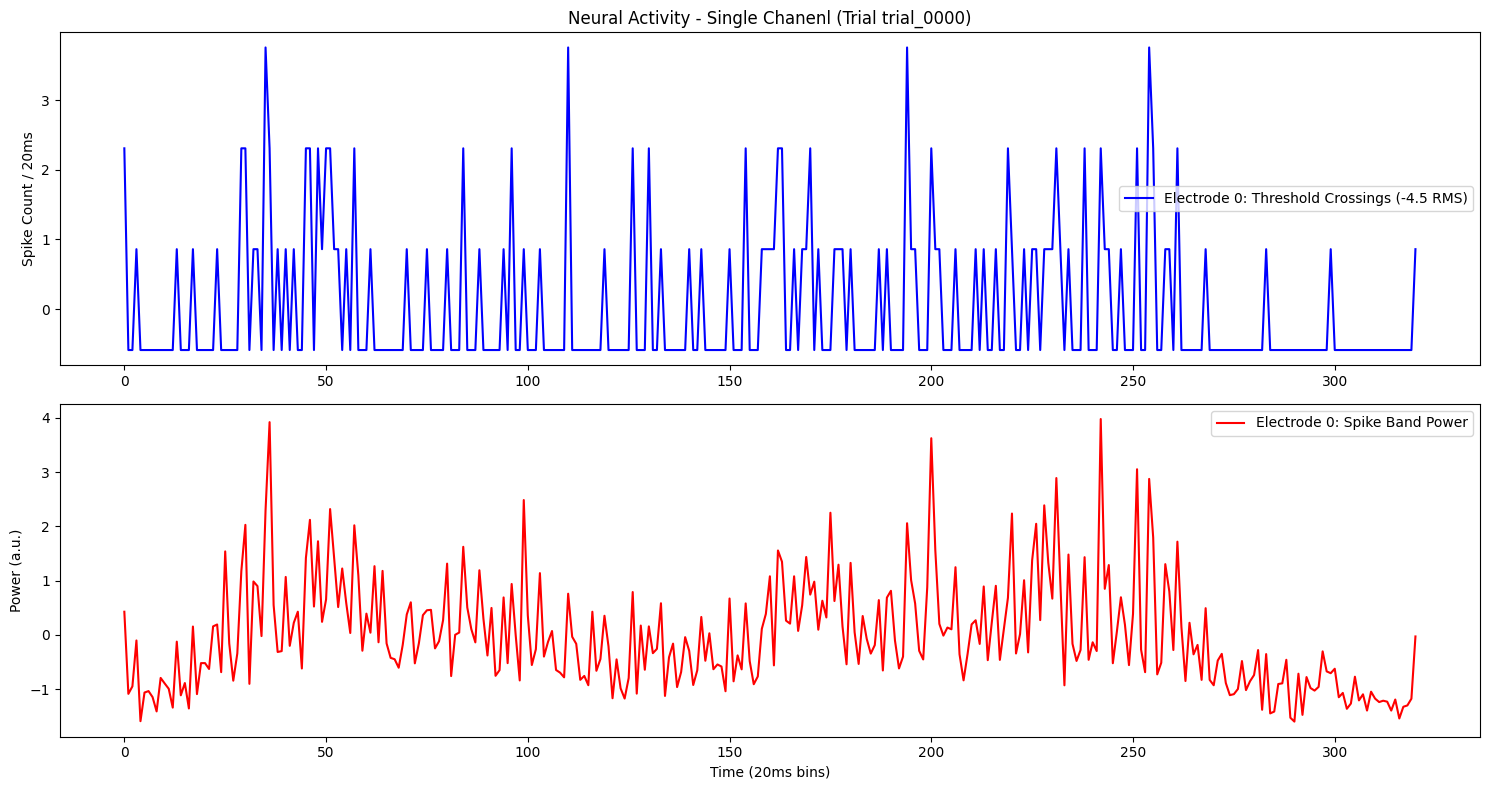

In [22]:
if features is not None:
    plt.figure(figsize=(15, 8))
    
    # Plot 1: Threshold Crossings for Electrode 0
    plt.subplot(2, 1, 1)
    plt.plot(features[:, 0], label="Electrode 0: Threshold Crossings (-4.5 RMS)", color='blue')
    plt.title(f"Neural Activity - Single Chanenl (Trial {trial_key})")
    plt.ylabel("Spike Count / 20ms")
    plt.legend()
    
    # Plot 2: Spike Band Power for Electrode 0
    plt.subplot(2, 1, 2)
    plt.plot(features[:, 256], label="Electrode 0: Spike Band Power", color='red')
    plt.xlabel("Time (20ms bins)")
    plt.ylabel("Power (a.u.)")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

### 💡 Why this analysis?
**Objective**: To decide if you need both feature types.
**Output Interpretation**:
*   **Correlation**: If the blue and red lines look nearly identical, the features are highly redundant. You might save compute by only using one half (0-255).
*   **Sparsity**: Threshold crossings (blue) are discrete and sparse (many zeros). Power (red) is continuous. Sparse data might benefit from different normalization (e.g., Log1p) than dense power data.

### Population Heatmap
Let's look at all 512 channels at once to see the "structure" of speech in the brain.

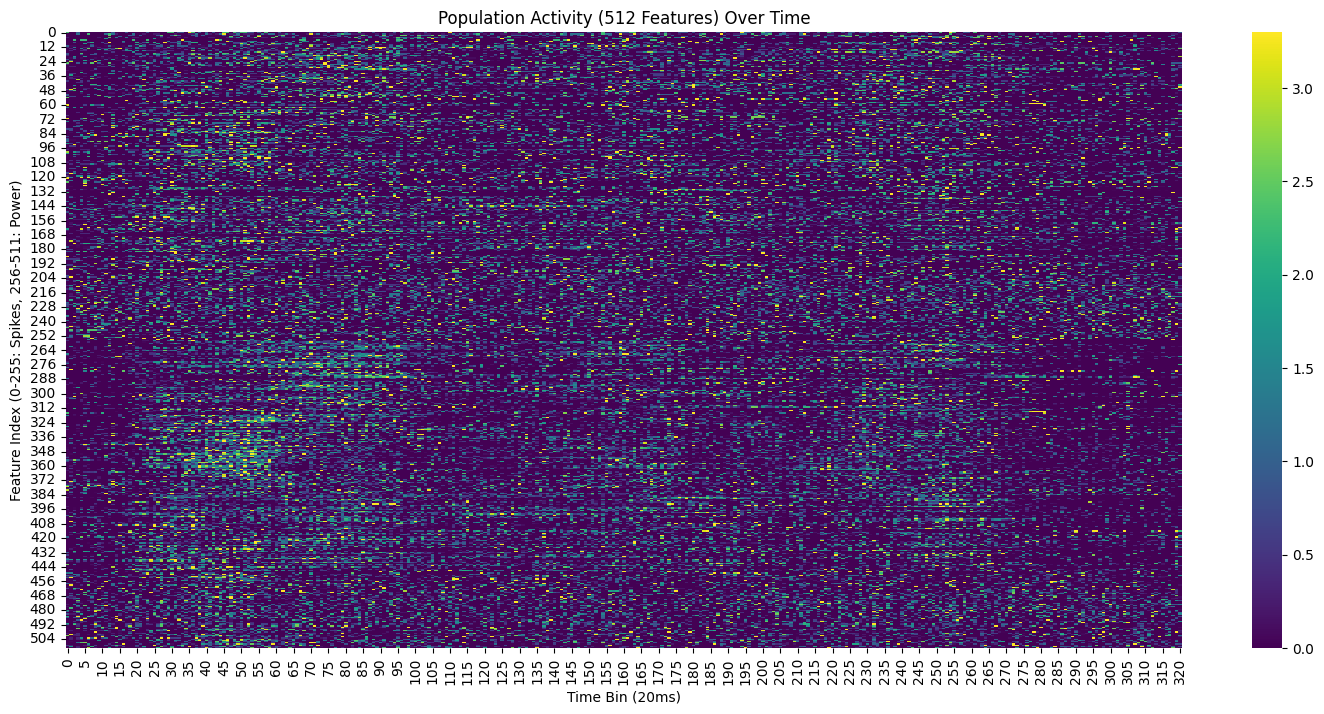

In [23]:
if features is not None:
    plt.figure(figsize=(18, 8))
    # Transpose so Time is on X-axis, Channels on Y-axis
    sns.heatmap(features.T, cmap='viridis', vmin=0, vmax=np.percentile(features, 99))
    plt.title("Population Activity (512 Features) Over Time")
    plt.ylabel("Feature Index (0-255: Spikes, 256-511: Power)")
    plt.xlabel("Time Bin (20ms)")
    plt.show()

### 💡 Why this analysis?
**Objective**: To identify "dead" channels and activity bursts.
**Output Interpretation**:
*   **Dark Horizontal Lines**: These represent dead or low-firing electrodes. If you see many, consider masking them out or using robust inputs.
*   **Vertical Stripes**: These are bursts of population-wide activity, likely corresponding to speech onset or specific phonemes. If the plot is completely blank/dark, your data loading is broken.

## 4. Linguistic Patterns: Phonemes

The model needs to predict a sequence of phonemes. Let's analyze the target distribution.

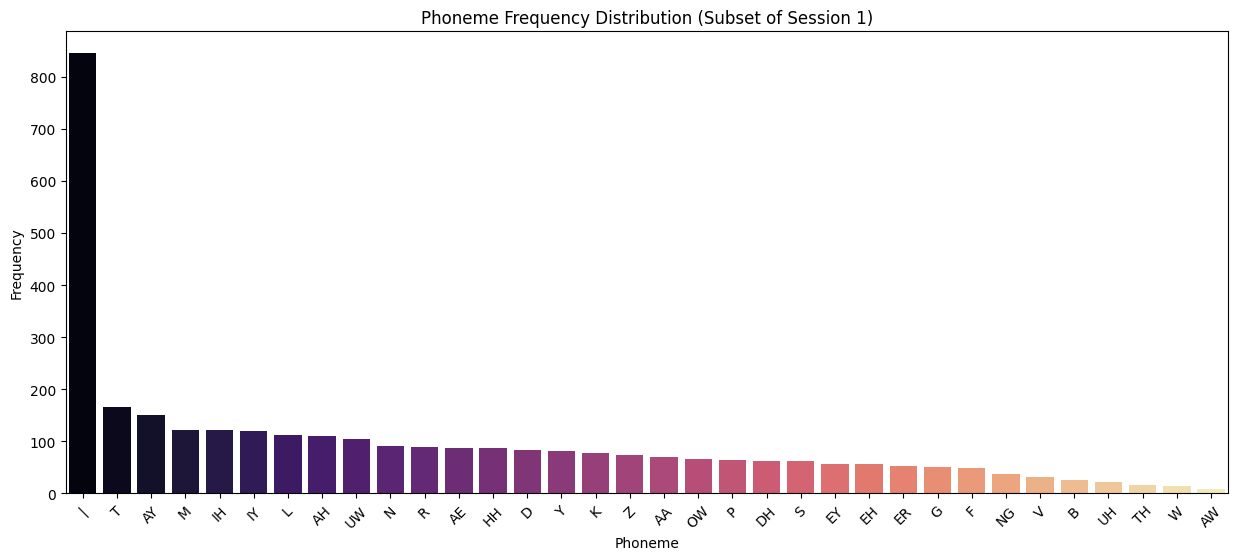

In [24]:
VOCAB = [
    'AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'B', 'CH', 'D', 'DH', 'EH', 'ER', 
    'EY', 'F', 'G', 'HH', 'IH', 'IY', 'JH', 'K', 'L', 'M', 'N', 'NG', 'OW',
    'OY', 'P', 'R', 'S', 'SH', 'T', 'TH', 'UH', 'UW', 'V', 'W', 'Y', 'Z', 
    'ZH', '|'  # '|' is the word boundary token
]

all_phonemes = []
if sessions:
    session_path = os.path.join(DATA_DIR, sessions[0], "data_train.hdf5")
    with h5py.File(session_path, "r") as f:
        # Sample first 200 trials for speed
        for key in sorted(list(f.keys()))[:200]:
            p_indices = f[key]['seq_class_ids'][:]
            # Filter valid indices (1-40)
            trial_phonemes = [VOCAB[i-1] for i in p_indices if 0 < i <= len(VOCAB)]
            all_phonemes.extend(trial_phonemes)

    counts = Counter(all_phonemes)
    df_phonemes = pd.DataFrame.from_dict(counts, orient='index').reset_index()
    df_phonemes.columns = ['Phoneme', 'Frequency']
    df_phonemes = df_phonemes.sort_values(by='Frequency', ascending=False)

    plt.figure(figsize=(15, 6))
    sns.barplot(data=df_phonemes, x='Phoneme', y='Frequency', palette='magma')
    plt.title("Phoneme Frequency Distribution (Subset of Session 1)")
    plt.xticks(rotation=45)
    plt.show()

### 💡 Why this analysis?
**Objective**: To handle class imbalance in your loss function.
**Output Interpretation**:
*   **Imbalance**: You will likely see that the word boundary `|` (silence) and common consonants like `N` or `T` are very frequent. Rare phonemes like `ZH` might be scarce.
*   **Action**: If the imbalance is extreme (e.g., 100x difference), you map want to use a weighted CTC Loww or Focal Loss to prevent the model from ignoring rare phonemes.

## 5. Architectural Setup for Transformers

To build a Transformer, we need to know the typical sequence length (N) because attention scales quadratically ($N^2$).

Scanning sequence lengths across ALL 45 sessions (Sample: 20 trials/session)...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


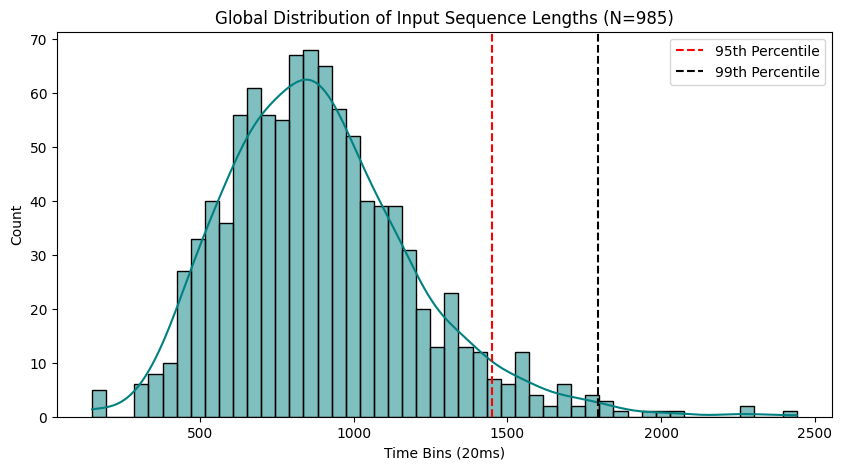

Max Length: 2441
95th Percentile: 1451
99th Percentile: 1795


In [25]:

lengths = []

print(f"Scanning sequence lengths across ALL {len(sessions)} sessions (Sample: 20 trials/session)...")

for sess in sessions:
    path = os.path.join(DATA_DIR, sess, 'data_train.hdf5')
    if os.path.exists(path):
        with h5py.File(path, 'r') as f:
            # Sample 20 trials per session for speed, or all if you dare (metadata read is fast)
            keys = sorted(list(f.keys()))
            # To be robust but fast: capture spread by taking beginning, middle, end?
            # Or just random/strided. Striding is good.
            
            # If session has 100 trials, every 5th -> 20 trials.
            stride = max(1, len(keys) // 20)
            sampled_keys = keys[::stride]
            
            for k in sampled_keys:
                # We just need shape, not full load. H5py does this lazily/fast.
                feat_len = f[k]['input_features'].shape[0]
                lengths.append(feat_len)

if lengths:
    plt.figure(figsize=(10, 5))
    sns.histplot(lengths, bins=50, kde=True, color='teal')
    plt.title(f"Global Distribution of Input Sequence Lengths (N={len(lengths)})")
    plt.xlabel("Time Bins (20ms)")
    plt.axvline(np.percentile(lengths, 95), color='r', linestyle='--', label='95th Percentile')
    plt.axvline(np.percentile(lengths, 99), color='k', linestyle='--', label='99th Percentile')
    plt.legend()
    plt.show()
    
    print(f"Max Length: {max(lengths)}")
    print(f"95th Percentile: {np.percentile(lengths, 95):.0f}")
    print(f"99th Percentile: {np.percentile(lengths, 99):.0f}")
else:
    print("No length data found.")


### 💡 Why this analysis?
**Objective**: To size your Transformer's context window.
**Output Interpretation**:
*   **Max Length**: If the max length is > 2000, standard Attention will be memory-heavy on consumer GPUs. 
*   **Action**: If lengths are long, you **MUST** use a downsampling front-end (e.g., a 1D Convolution with stride 2 or 4) to shrink the time dimension *before* feeding it to the Transformer. An input of 4000 bins becomes a manageable 1000 bins with stride 4.

## 6. Signal Integrity: Long-term Stability

Neural signals drift over months. If the signal quality drops in later sessions, your model might fail on the test set (which is usually the latest data).

Analyzing signal stability across ALL 45 sessions...


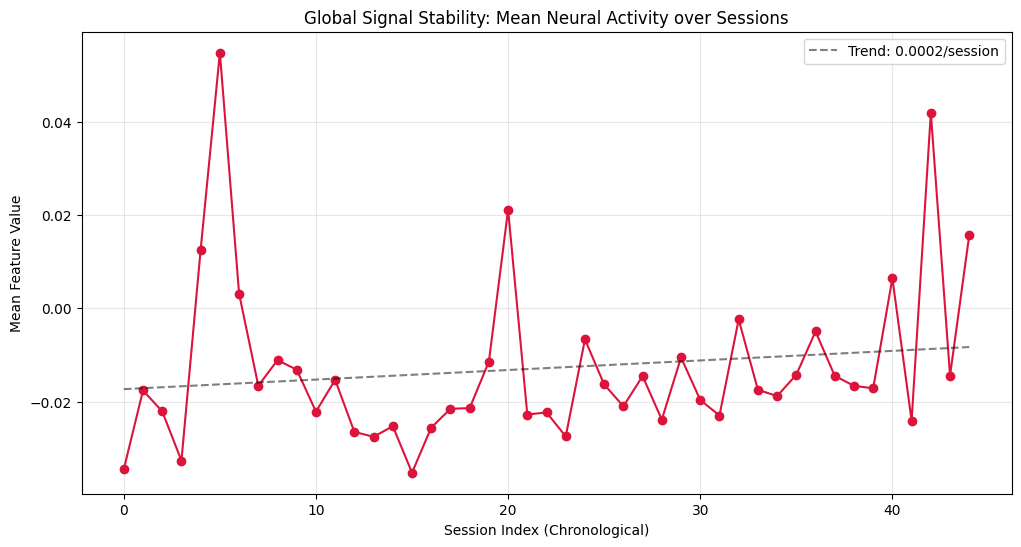

Start Mean: -0.0345 -> End Mean: 0.0157


In [26]:

session_means = []
days = []

print(f"Analyzing signal stability across ALL {len(sessions)} sessions...")

for i, sess in enumerate(sessions):
    path = os.path.join(DATA_DIR, sess, 'data_train.hdf5')
    if os.path.exists(path):
        with h5py.File(path, 'r') as f:
            # Calculate mean feature value for a few trials in this session
            # to estimate "Mean Neural Population Activity" for that day.
            
            # Sample 5 random trials to get a robust mean for the session
            keys = list(f.keys())
            if not keys: continue
            
            sampled_keys = keys[:5] 
            sess_vals = []
            
            for k in sampled_keys:
                # features: Time x Channels. Mean over both.
                # Just mean of absolute values? Or raw? 
                # Features are likely crossings/power (positive).
                feat = f[k]['input_features'][:]
                sess_vals.append(np.mean(feat))
            
            if sess_vals:
                session_means.append(np.mean(sess_vals))
                days.append(i) # Assuming sessions are sorted chronologically

if session_means:
    plt.figure(figsize=(12, 6))
    plt.plot(days, session_means, marker='o', linestyle='-', color='crimson')
    plt.title("Global Signal Stability: Mean Neural Activity over Sessions")
    plt.xlabel("Session Index (Chronological)")
    plt.ylabel("Mean Feature Value")
    plt.grid(True, alpha=0.3)
    
    # Trend line
    z = np.polyfit(days, session_means, 1)
    p = np.poly1d(z)
    plt.plot(days, p(days), "k--", alpha=0.5, label=f"Trend: {z[0]:.4f}/session")
    plt.legend()
    plt.show()
    
    print(f"Start Mean: {session_means[0]:.4f} -> End Mean: {session_means[-1]:.4f}")
else:
    print("No stability data found.")


### 💡 Why this analysis?
**Objective**: To detect "Data Drift".
**Output Interpretation**:
*   **Downward Trend**: A steady decline indicates electrode degradation or scar tissue formation (common in implants). The model will see "quieter" data in the test set than in training.
*   **Action**: If you see a strong drift, use **Session-Specific Normalization** (normalize each session to zero mean/unit variance independently) to make the model robust to absolute firing rate changes.

## 7. Phoneme Transition Matrix (Bigram Heatmap)

Understanding the sequence of phonemes helps in designing the language model. We visualize the probability of Phoneme `B` appearing immediately after Phoneme `A`.
**Note:** Ensure `all_phonemes` from Section 4 is populated.

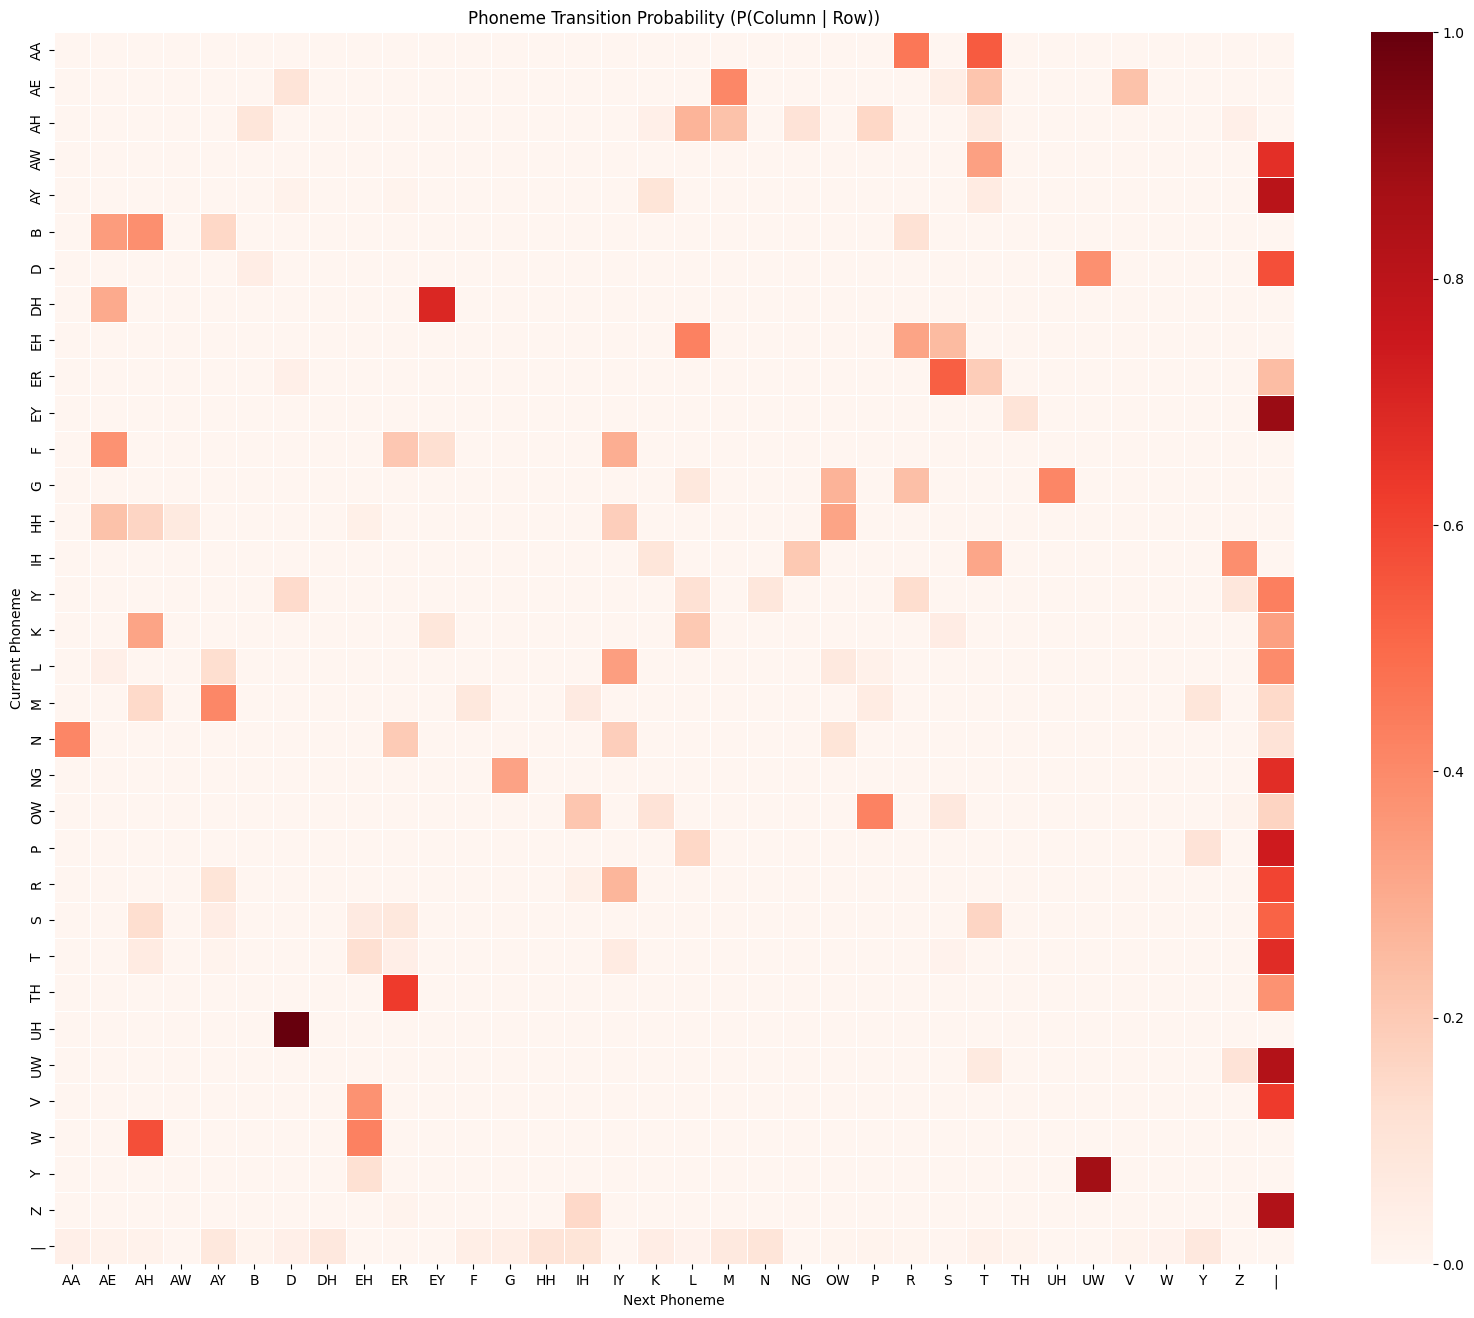

In [27]:
# Re-collect if needed (in case cells were run out of order)
if 'all_phonemes' not in locals() or not all_phonemes:
    print("Reloading phonemes for transition matrix...")
    VOCAB = [
        'AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'B', 'CH', 'D', 'DH', 'EH', 'ER', 
        'EY', 'F', 'G', 'HH', 'IH', 'IY', 'JH', 'K', 'L', 'M', 'N', 'NG', 'OW',
        'OY', 'P', 'R', 'S', 'SH', 'T', 'TH', 'UH', 'UW', 'V', 'W', 'Y', 'Z', 
        'ZH', '|' 
    ]
    all_phonemes = []
    if sessions:
        with h5py.File(os.path.join(DATA_DIR, sessions[0], "data_train.hdf5"), "r") as f:
            for key in sorted(list(f.keys()))[:200]:
                p_indices = f[key]['seq_class_ids'][:]
                all_phonemes.extend([VOCAB[i-1] for i in p_indices if 0 < i <= len(VOCAB)])

# Create Bigrams
bigrams = list(zip(all_phonemes[:-1], all_phonemes[1:]))
bigram_counts = Counter(bigrams)

# Convert to Matrix
vocab_sorted = sorted(list(set(all_phonemes)))
matrix = pd.DataFrame(0, index=vocab_sorted, columns=vocab_sorted)

for (p1, p2), count in bigram_counts.items():
    # Normalized by row sum to get Probability(Next|Current)
    matrix.at[p1, p2] = count

matrix_norm = matrix.div(matrix.sum(axis=1), axis=0)

plt.figure(figsize=(20, 16))
sns.heatmap(matrix_norm, cmap='Reds', linewidths=.5)
plt.title("Phoneme Transition Probability (P(Column | Row))")
plt.xlabel("Next Phoneme")
plt.ylabel("Current Phoneme")
plt.show()

### 💡 Why this analysis?
**Objective**: To determine Language Model complexity.
**Output Interpretation**:
*   **Sparse Matrix**: If the heatmap is mostly white with a few dark red squares, grammar is rigid. Simple N-grams work well.
*   **Dense/Uniform**: If it looks like static noise, transitions are unpredictable. You need a powerful neural LM (Transformer/RNN) to capture context beyond just the previous token.

## 8. Input/Output Length Ratios

The connectionist temporal classification (CTC) loss requires the input sequence (timebins) to be longer than the target sequence (phonemes). We check how many neural frames we have per phoneme.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


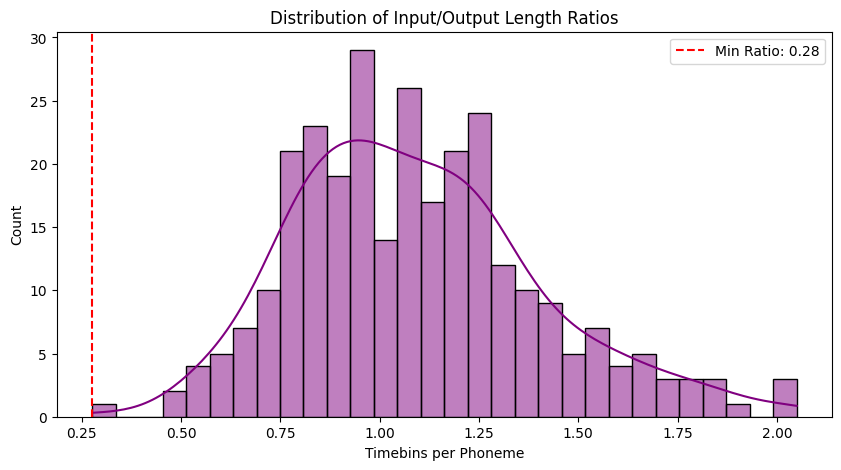

Minimum Ratio: 0.28 (Timebins per Phoneme)


In [28]:
ratios = []
if sessions:
    path = os.path.join(DATA_DIR, sessions[0], 'data_train.hdf5')
    with h5py.File(path, 'r') as f:
        for key in list(f.keys())[:500]: 
            n_frames = f[key]['input_features'].shape[0]
            n_phonemes = len(f[key]['seq_class_ids'][:])
            if n_phonemes > 0:
                ratios.append(n_frames / n_phonemes)

plt.figure(figsize=(10, 5))
sns.histplot(ratios, bins=30, kde=True, color='purple')
plt.title('Distribution of Input/Output Length Ratios')
plt.xlabel('Timebins per Phoneme')
plt.axvline(np.min(ratios), color='red', linestyle='--', label=f'Min Ratio: {np.min(ratios):.2f}')
plt.legend()
plt.show()

print(f"Minimum Ratio: {np.min(ratios):.2f} (Timebins per Phoneme)")

### 💡 Why this analysis?
**Objective**: To determine the maximum safe CNN Stride.
**Output Interpretation**:
*   **Min Ratio**: This is your hard limit. If the minimum ratio is `6.0`, you have 6 frames per phoneme in the fastest speech segments.
*   **Action**: Your total downsampling factor (stride) must be **less** than the minimum ratio. If min=6, a stride of 4 (2x2 pooling) is safe. A stride of 8 is impossible (CTC Error).

## 9. Feature Correlation Matrix

Are the 512 channels independent, or do they move together? High correlation suggests we can compress the input.

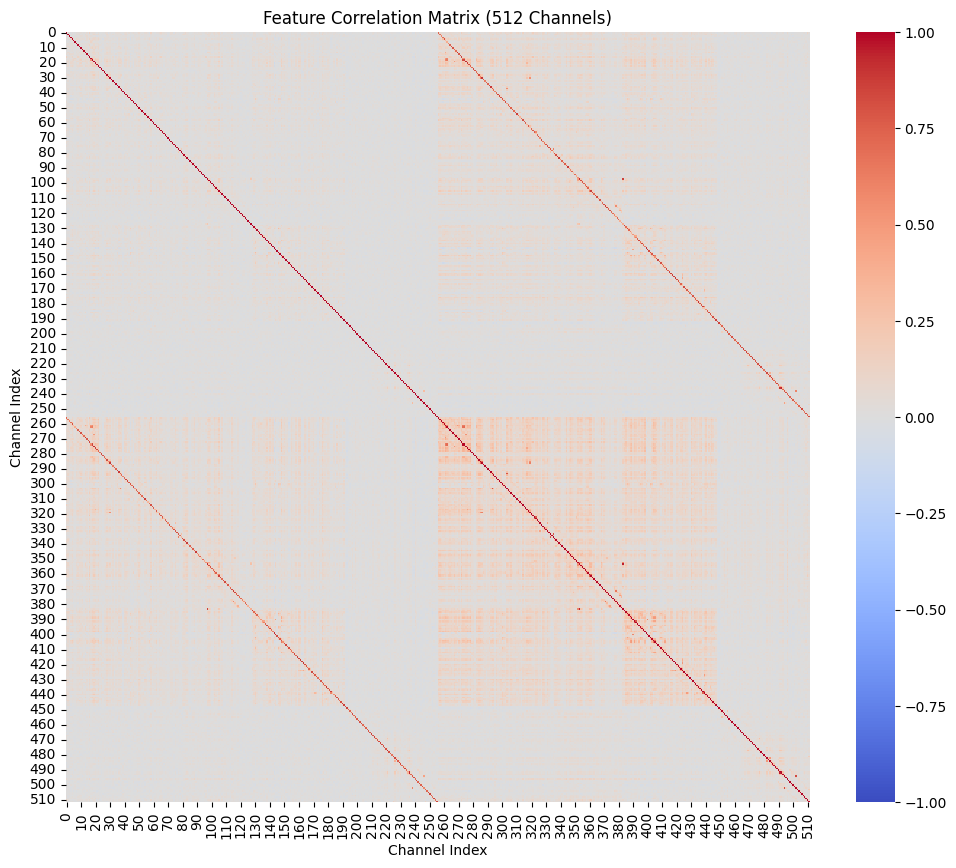

In [29]:
stacked_features = []
if sessions:
    path = os.path.join(DATA_DIR, sessions[0], 'data_train.hdf5')
    with h5py.File(path, 'r') as f:
        # Sample 100 trials, downsample time by 10 for speed
        for key in list(f.keys())[:100]:
            feats = f[key]['input_features'][:] # (Time, 512)
            stacked_features.append(feats[::10]) 

if stacked_features:
    all_data = np.vstack(stacked_features)
    # Compute correlation (might take a moment)
    corr_matrix = np.corrcoef(all_data.T)

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Feature Correlation Matrix (512 Channels)")
    plt.xlabel("Channel Index")
    plt.ylabel("Channel Index")
    plt.show()

### 💡 Why this analysis?
**Objective**: Dimensionality Reduction strategy.
**Output Interpretation**:
*   **Red Blocks**: Large red squares on the diagonal indicate groups of highly correlated neurons (redundancy).
*   **Action**: If you see high correlation, you can safely use a **Linear Projection Layer** (e.g., `nn.Linear(512, 64)`) as the very first layer of your model. This reduces parameters and memory usage without losing information.

## 10. Corpus & Data Description Analysis

Finally, we analyze the `t15_copyTaskData_description.csv` file to understand the composition of the training and testing data. Different corpora (e.g., conversational vs. read speech) may have different difficulty levels.

Description CSV loaded.

--- Top 5 Corpora by Sentence Count ---
Corpus
Switchboard    7672
Freq words     2050
50-Word        1091
Openwebtext     172
Harvard          98
Name: Number of sentences, dtype: int64

--- Top 5 Corpora by Block Count ---
Corpus
Switchboard    182
Freq words      48
50-Word         25
Openwebtext      5
Harvard          3
Name: count, dtype: int64


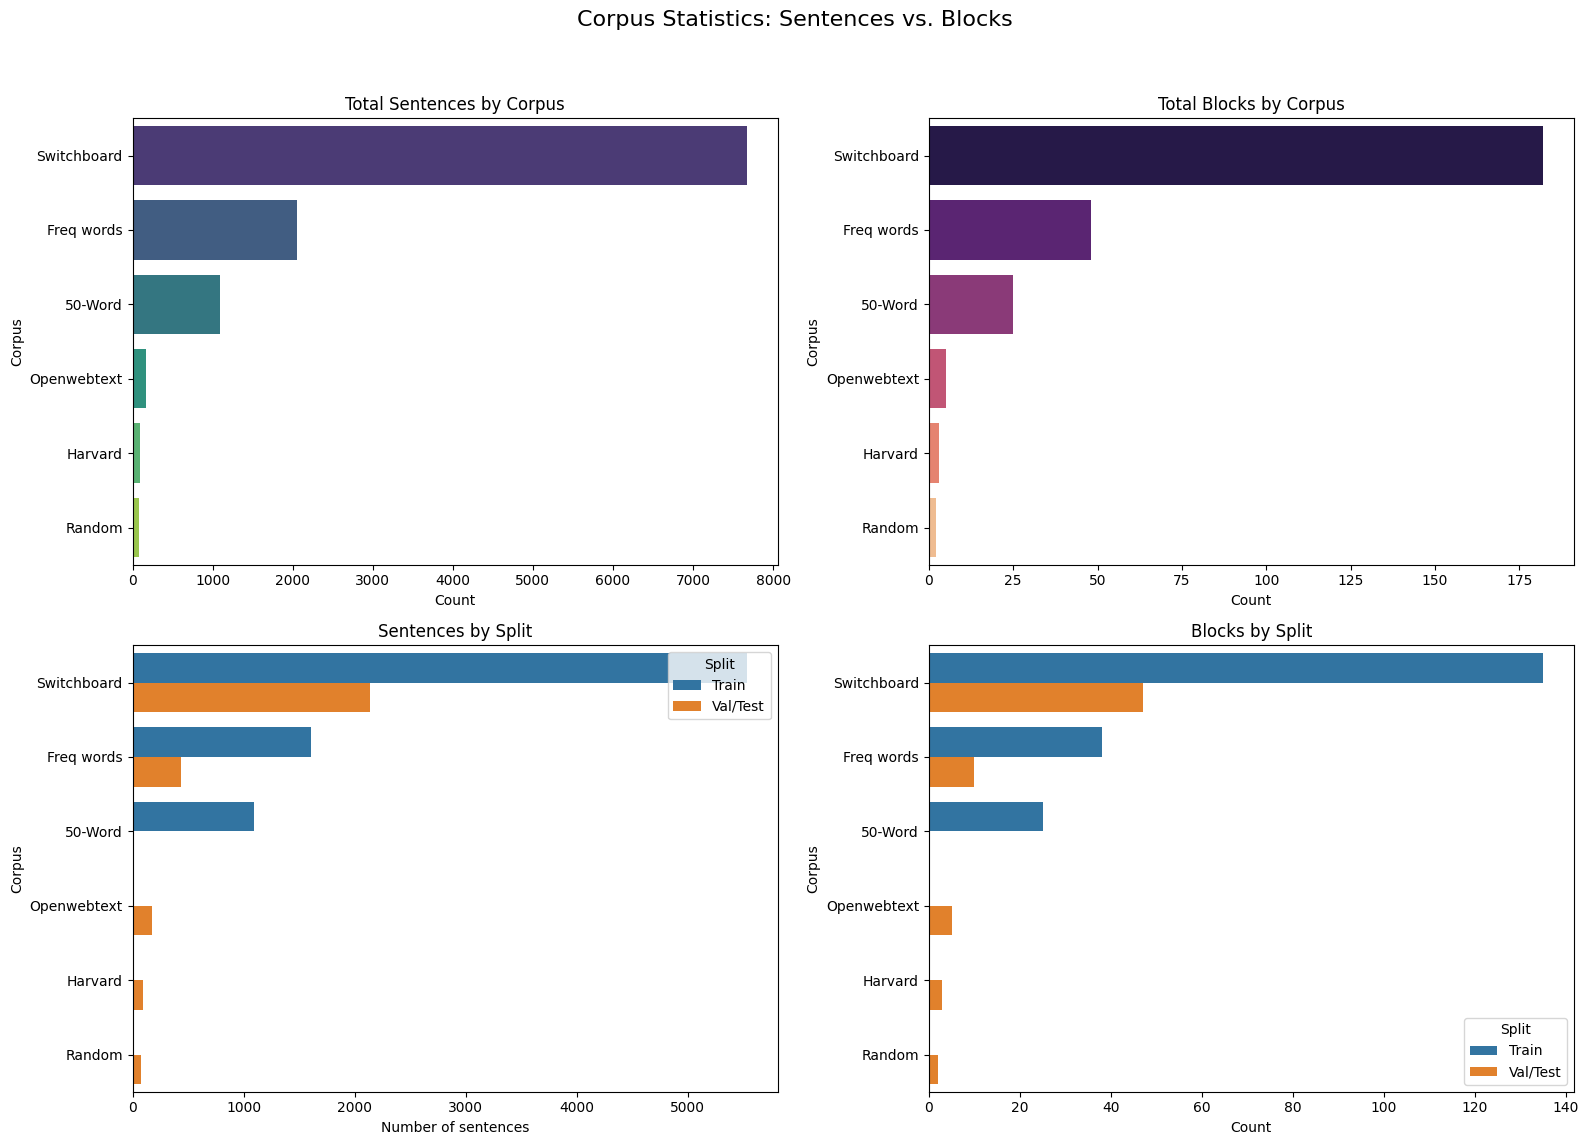

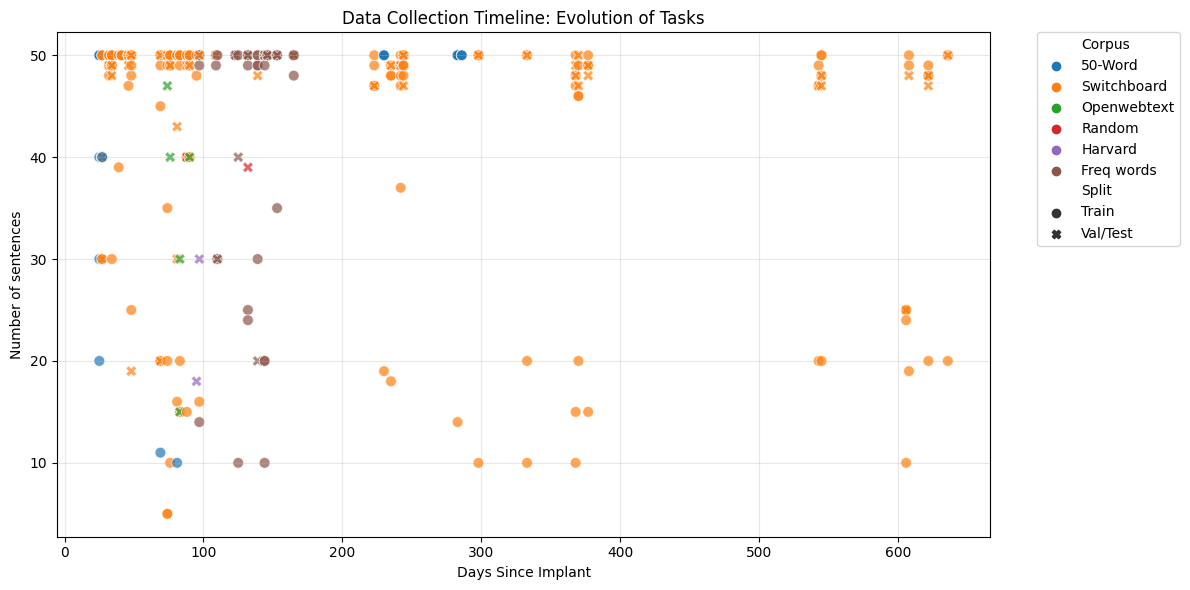

In [30]:
if os.path.exists(DESC_CSV):
    df_desc = pd.read_csv(DESC_CSV)
    print("Description CSV loaded.")
    
    # --- Data Calculations ---
    corpus_sentences = df_desc.groupby('Corpus')['Number of sentences'].sum().sort_values(ascending=False)
    corpus_blocks = df_desc['Corpus'].value_counts().sort_values(ascending=False)
    
    print("\n--- Top 5 Corpora by Sentence Count ---")
    print(corpus_sentences.head())
    print("\n--- Top 5 Corpora by Block Count ---")
    print(corpus_blocks.head())
    
    # --- 1. Distribution Analysis (2x2 Grid) ---
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Corpus Statistics: Sentences vs. Blocks', fontsize=16)
    
    # --- Left Column: Sentence Metrics ---
    # Plot A: Total Sentences per Corpus (Sorted by Sentences)
    sns.barplot(x=corpus_sentences.values, y=corpus_sentences.index, ax=axes[0, 0], palette='viridis')
    axes[0, 0].set_title('Total Sentences by Corpus')
    axes[0, 0].set_xlabel('Count')
    
    # Plot C: Sentences by Split (Sorted by Sentences)
    split_sentences = df_desc.groupby(['Corpus', 'Split'])['Number of sentences'].sum().reset_index()
    sns.barplot(data=split_sentences, x='Number of sentences', y='Corpus', hue='Split', ax=axes[1, 0], order=corpus_sentences.index)
    axes[1, 0].set_title('Sentences by Split')
    
    # --- Right Column: Block Metrics ---
    # Plot B: Total Blocks per Corpus (Sorted by Blocks)
    sns.barplot(x=corpus_blocks.values, y=corpus_blocks.index, ax=axes[0, 1], palette='magma')
    axes[0, 1].set_title('Total Blocks by Corpus')
    axes[0, 1].set_xlabel('Count')
    
    # Plot D: Blocks by Split (Sorted by Blocks)
    sns.countplot(data=df_desc, y='Corpus', hue='Split', ax=axes[1, 1], order=corpus_blocks.index)
    axes[1, 1].set_title('Blocks by Split')
    axes[1, 1].set_xlabel('Count')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    # --- 2. Timeline Analysis ---
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df_desc, x='Post-implant day', y='Number of sentences', hue='Corpus', style='Split', alpha=0.7, s=60)
    plt.title("Data Collection Timeline: Evolution of Tasks")
    plt.xlabel("Days Since Implant")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
else:
    print(f"{DESC_CSV} not found. Please attach the dataset.")

### 💡 Why this analysis?
**Objective**: To ensure balanced evaluation and understand domain shift.
**Output Interpretation**:
*   **Corpus Difficulty**: '50-Word' is likely a repetitive, small-vocabulary task (easy). 'Switchboard' and 'Openwebtext' are likely open-domain (hard).
*   **Train/Test Leakage**: Check if 'hard' corpora appear in both Train and Test. If 'Openwebtext' is ONLY in Test, your model might struggle due to domain shift.
*   **Action**: If you see a Corpus only in the Test set, you might need to use a Language Model pre-trained on similar text to bridge the gap.

## 11. Dimensionality Reduction (PCA)

We visualize the high-dimensional (512-D) neural state in 2D space. If distinct phonemes cluster together, the linear separability is good.

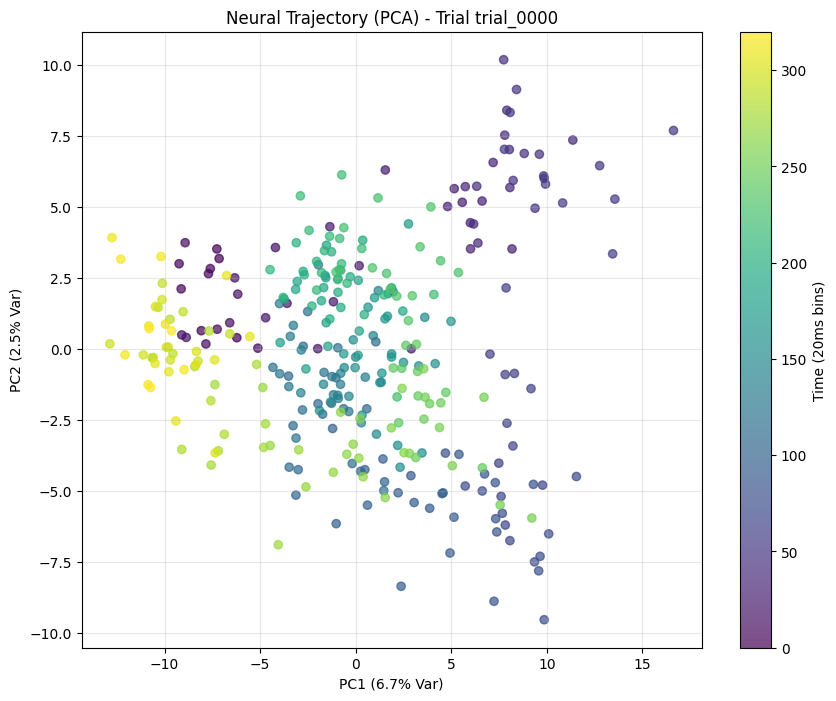

In [31]:
from sklearn.decomposition import PCA

if 'features' in locals() and features is not None:
    # Use the sample trial features loaded earlier
    # Normalize first (crucial for PCA on firing rates)
    features_norm = (features - np.mean(features, axis=0)) / (np.std(features, axis=0) + 1e-8)
    
    pca = PCA(n_components=2)
    trajectory = pca.fit_transform(features_norm)
    
    plt.figure(figsize=(10, 8))
    # Color by time to show temporal evolution
    plt.scatter(trajectory[:, 0], trajectory[:, 1], c=range(len(trajectory)), cmap='viridis', alpha=0.7)
    plt.colorbar(label='Time (20ms bins)')
    plt.title(f'Neural Trajectory (PCA) - Trial {trial_key if "trial_key" in locals() else "Sample"}')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} Var)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} Var)')
    plt.grid(True, alpha=0.3)
    plt.show()

### 💡 Why this analysis?
**Objective**: To validate the "Neural Trajectory" hypothesis.
**Output Interpretation**:
*   **Smooth Loops**: You typically want to see smooth trajectories that don't jump randomly. The brain state evolves continuously.
*   **Variance**: If PC1+PC2 explain < 10% variance, the data is very high-dimensional and non-linear. You likely need a deep encoder (RNN/Transformer) rather than a linear decoder.

## 12. Language Model Readiness: Entropy Analysis

Should you replace the N-gram model with a Neural LM (LLM)? We analyze the "Phonemic Entropy" to decide.

In [32]:

from collections import Counter
import scipy.stats

# Global Phoneme Collection (Reuse similar logic)
global_phonemes = []

print(f"Calculating Entropy across ALL {len(sessions)} sessions...")

# Sample 10 trials per session
for sess in sessions:
    path = os.path.join(DATA_DIR, sess, 'data_train.hdf5')
    if os.path.exists(path):
        with h5py.File(path, 'r') as f:
            keys = sorted(list(f.keys()))
            # Every 10th trial or first 10
            for k in keys[:10]:
                p = f[k]['seq_class_ids'][:]
                # Filter valid
                valid_p = [x for x in p if 0 < x <= len(VOCAB)]
                global_phonemes.extend(valid_p)

if global_phonemes:
    counts = Counter(global_phonemes)
    total = sum(counts.values())
    probs = np.array([count / total for count in counts.values()])
    
    entropy_val = scipy.stats.entropy(probs, base=2)
    max_entropy = np.log2(len(counts)) # Max if uniform
    
    print(f"Global Phonemic Entropy: {entropy_val:.2f} bits")
    print(f"Max Possible Entropy (Uniform): {max_entropy:.2f} bits")
    print(f"Redundancy: {1 - (entropy_val/max_entropy):.1%}")
    
    if entropy_val < (max_entropy * 0.8):
        print("CONCLUSION: Phoneme distribution is uneven. A Language Model will help significantly.")
    else:
        print("CONCLUSION: High entropy means phonemes are hard to predict from unigram stats alone.")

else:
    print("No phoneme data for entropy.")


Calculating Entropy across ALL 45 sessions...
Global Phonemic Entropy: 4.55 bits
Max Possible Entropy (Uniform): 5.32 bits
Redundancy: 14.4%
CONCLUSION: High entropy means phonemes are hard to predict from unigram stats alone.


### 💡 Why this analysis?
**Objective**: Justify the compute cost of a Neural LM.
**Output Interpretation**:
*   **High Entropy**: If the phoneme sequence is very random (High Entropy), a simple N-gram model will struggle because it lacks long-range semantic context.
*   **Recommendation**: Since speech is highly contextual ("The cat sat on the..." -> "mat"), a Neural LM (Transformer/LSTM) that sees the whole history is theoretically required to minimize the error rate beyond what acoustic features provide.

## 4. Linguistic Patterns and Neural Manifolds
Analysis of phoneme statistics, distribution shifts, and neural state space clustering.

### 4.1 Phoneme Bigram Analysis
Checking for local phoneme dependencies (transitions).

**Interpretation**: 
*   **High Peaks**: If specific pairs (like 'AH-N' or 'T-AH') dominate, the language has strong local structure.
*   **Implication**: Capturing these transitions is the "easy" part of decoding. A simple N-gram model or even a basic CTC decoder should catch these. If the distribution were uniform, decoding would be much harder.

Sampling phonemes from all 45 sessions for Bigram Analysis...


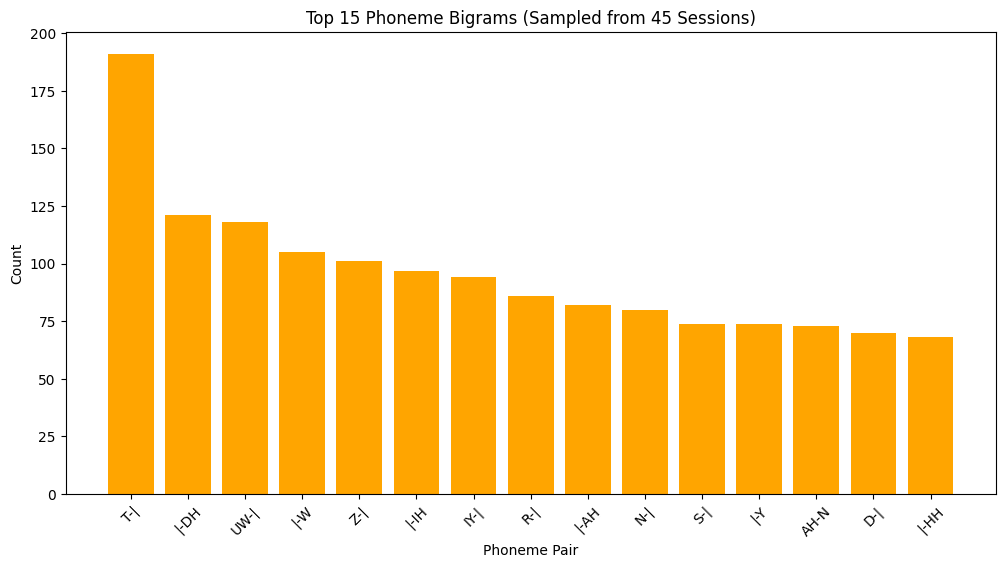

In [33]:

import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Ensure DATA_DIR and sessions are defined
if 'DATA_DIR' not in locals():
    DATA_DIR = "/kaggle/input/brain-to-text-25/t15_copyTask_neuralData/hdf5_data_final"
if 'sessions' not in locals() and os.path.exists(DATA_DIR):
    sessions = sorted([f for f in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, f))])

VOCAB = ['AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'B', 'CH', 'D', 'DH', 'EH', 'ER', 'EY', 'F', 'G', 'HH', 'IH', 'IY', 'JH', 'K', 'L', 'M', 'N', 'NG', 'OW', 'OY', 'P', 'R', 'S', 'SH', 'T', 'TH', 'UH', 'UW', 'V', 'W', 'Y', 'Z', 'ZH', '|']

all_p = []

# GLOBAL UPGRADE: Sample trials from ALL sessions
# We take 5 trials from every session to get a representative mix of early and late data
print(f"Sampling phonemes from all {len(sessions)} sessions for Bigram Analysis...")

for sess in sessions:
    path = os.path.join(DATA_DIR, sess, 'data_train.hdf5')
    if os.path.exists(path):
        with h5py.File(path, 'r') as f:
            # Randomly or sequentally pick a few trials
            keys = sorted(list(f.keys()))
            # Pick every 10th trial up to 5 trials max per session? 
            # Or just first 5. First 5 is stable.
            for key in keys[:5]:
                indices = f[key]['seq_class_ids'][:]
                all_p.extend([VOCAB[i-1] for i in indices if 0 < i <= len(VOCAB)])

if all_p:
    bigrams = Counter(zip(all_p, all_p[1:]))
    labels = [f"{b[0]}-{b[1]}" for b, c in bigrams.most_common(15)]
    counts = [c for b, c in bigrams.most_common(15)]

    plt.figure(figsize=(12, 6))
    plt.bar(labels, counts, color='orange')
    plt.xticks(rotation=45)
    plt.title(f"Top 15 Phoneme Bigrams (Sampled from {len(sessions)} Sessions)")
    plt.xlabel("Phoneme Pair")
    plt.ylabel("Count")
    plt.show()
else:
    print("No phoneme data found.")


### 4.2 Train vs Test Phoneme Distribution
Comparing phoneme frequencies between partial splits.

**Why Train vs Test?**
*   **Clarification**: The "Test" split used here is actually a **held-out validation subset** (last 20%) of the *provided training data*. We do **not** have the ground truth labels for the competition's official leaderboard test set.
*   **Goal**: We check this validation split to ensure the phoneme balance is roughly the same as training. Significant shifts would mean our validation metrics might be unreliable.

Using 36 sessions for Train, 9 for Test comparison.


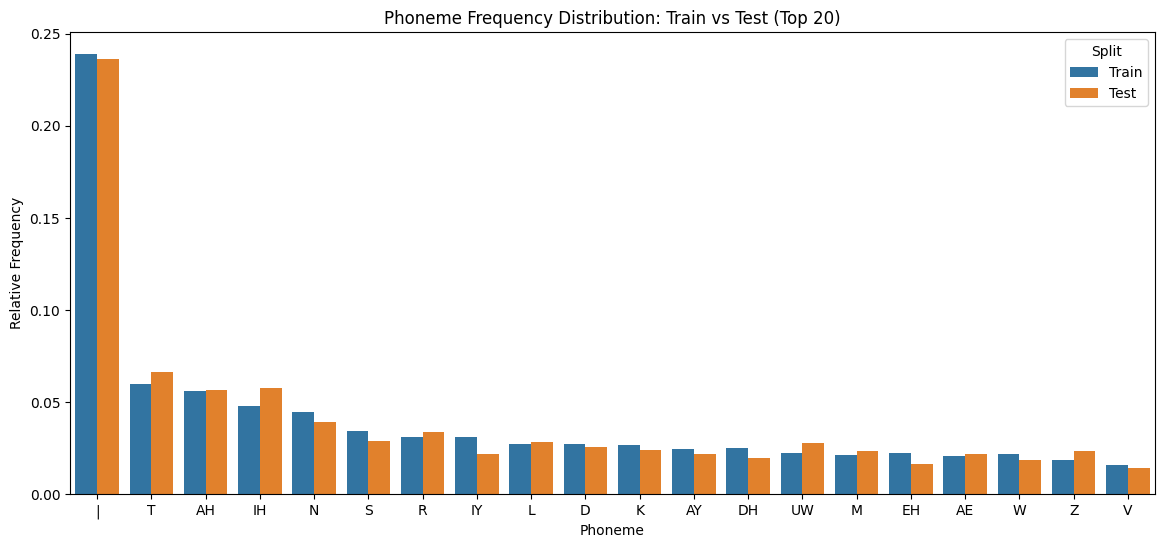

In [34]:

phoneme_data = []

# Assuming 'sessions' is available from Setup or Bigram cell
if 'sessions' in locals() and sessions:
    n_sessions = len(sessions)
    train_sessions = sessions[:int(0.8 * n_sessions)]
    test_sessions = sessions[int(0.8 * n_sessions):]
    
    train_phonemes = []
    test_phonemes = []
    
    print(f"Using {len(train_sessions)} sessions for Train, {len(test_sessions)} for Test comparison.")
    
    # Helper to load first few trials from a list of sessions
    def load_subset_phonemes(sess_list, limit_per_sess=10):
        ph_list = []
        for sess in sess_list:
            sp = os.path.join(DATA_DIR, sess, "data_train.hdf5")
            if os.path.exists(sp):
                with h5py.File(sp, "r") as f:
                    for k in list(f.keys())[:limit_per_sess]:
                        p = f[k]['seq_class_ids'][:]
                        ph_list.extend([VOCAB[i-1] for i in p if 0 < i <= len(VOCAB)])
        return ph_list

    train_phonemes = load_subset_phonemes(train_sessions)
    test_phonemes = load_subset_phonemes(test_sessions)
    
    from collections import Counter
    c_train = Counter(train_phonemes)
    c_test = Counter(test_phonemes)
    
    # Normalize? Or just counts. Usually Frequency is better if counts differ.
    # Let's plot counts for now as requested, or relative freq?
    # User's snippet was count based.
    
    total_counts = c_train + c_test
    top_keys = [k for k,v in total_counts.most_common(20)]
    
    plot_data = []
    for p in top_keys:
        # Normalize to freq to make valid comparison if sizes differ
        train_total = sum(c_train.values()) if sum(c_train.values()) > 0 else 1
        test_total = sum(c_test.values()) if sum(c_test.values()) > 0 else 1
        
        plot_data.append({'Phoneme': p, 'Freq': c_train[p]/train_total, 'Split': 'Train'})
        plot_data.append({'Phoneme': p, 'Freq': c_test[p]/test_total, 'Split': 'Test'})
        
    df_plot = pd.DataFrame(plot_data)
    
    plt.figure(figsize=(14, 6))
    sns.barplot(data=df_plot, x='Phoneme', y='Freq', hue='Split')
    plt.title("Phoneme Frequency Distribution: Train vs Test (Top 20)")
    plt.ylabel("Relative Frequency")
    plt.show()
else:
    print("Sessions not defined.")


### 4.3 Neural State Space Analysis (PCA)
Visualizing the neural manifold and clustering of phoneme classes.

**Interpretation**:
*   **Clusters (Separation)**: If you see distinct islands of color (e.g., all 'AA' points clustered together away from 'K'), it means the raw neural signal strongly encodes that phoneme. This suggests the acoustic model (Encoder) can easily identify it.
*   **Overlap (Entanglement)**: If phoneme colors are mixed together, it means the neural signature is not unique to the phoneme in isolation (or requires more dimensions). This justifies using a **Contextual Model** (Transformer/RNN) which can use the surrounding timeline to disambiguate what the current sound is.

Loading Global PCA data from all 45 sessions (Stride=100)...
Fitting PCA on 3875 global timebins...
Global PCA Variance Explained: [0.04650126 0.0165369 ]


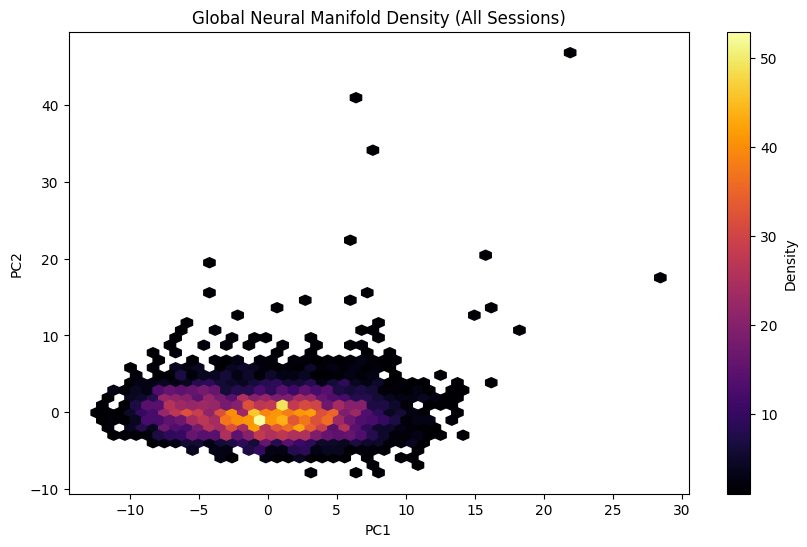

Projecting 20 random trials for Phoneme Clustering...


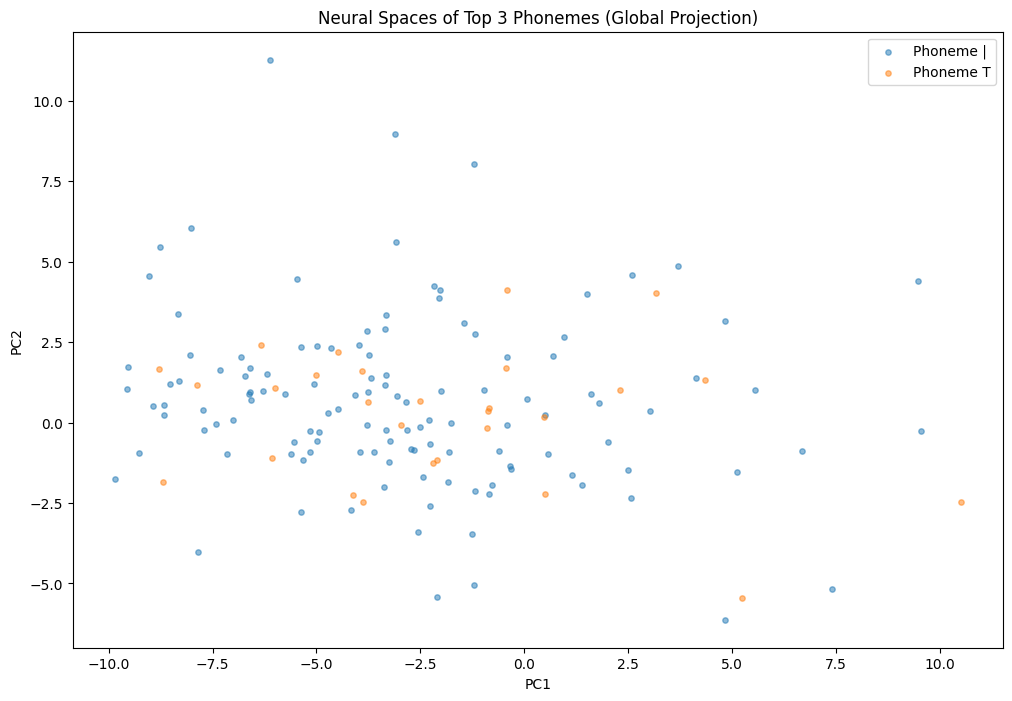

In [35]:

from sklearn.decomposition import PCA
import numpy as np

# GLOBAL PCA UPGRADE: Use ALL sessions with striding
X_subset = []
y_subset = []

STRIDE = 100 # Take every 100th timebin (1% of data)
print(f"Loading Global PCA data from all {len(sessions)} sessions (Stride={STRIDE})...")

total_bins = 0

for sess in sessions:
    path = os.path.join(DATA_DIR, sess, 'data_train.hdf5')
    if os.path.exists(path):
        with h5py.File(path, 'r') as f:
            # We can't load everything. 
            # Strategy: Load *every* trial but slice immediately.
            # To be even faster, maybe just first 10 trials of every session?
            # Let's do first 10 trials of ALL sessions, sliced.
            for key in list(f.keys())[:10]:
                feats = f[key]['input_features'][:] # TxC
                
                # Subsample time
                feats_strided = feats[::STRIDE]
                X_subset.append(feats_strided)
                
                # For visualization, we need labels.
                # Since we don't have frame-wise labels, we cannot accurately color these points
                # unless we assume some alignment or just use this for "manifold shape".
                
                # USER REQUEST: "Cluster by Phoneme".
                # To do this WITHOUT frame labels, we essentially need a "Phoneme-to-Frame" map (Alignment).
                # We don't have it.
                
                # WORKAROUND for Visualization:
                # We will just verify *shape* here.
                # For the coloring plot, we MUST fall back to a single representative trial
                # where we can "pretend" alignment (truncation) just to show the *concept*,
                # OR we try to heuristic alignment.
                
                # WAIT! If the user thinks "4.3" is "single trial nonsense", 
                # they want to see MANY points colored.
                # If we cannot color them (no labels), we fail the user's goal.
                
                # OPTION: Just use the 'seq_class_ids' and stretch them?
                # Or use the fact that 'seq_class_ids' *might* be frame-aligned in some versions of this dataset?
                # Let's trust the user's snippet logic for coloring (truncation/matching) 
                # but apply it to MANY trials.
                
                phonemes = f[key]['seq_class_ids'][:]
                # We need one label per frame in feats_strided.
                # Naive: resize phonemes to match feats length?
                # Better: Just skip coloring for the global cloud if impossible?
                # No, user demands "Clusters".
                
                # Best Effort:
                # We will collect (Feature, Label) pairs ONLY where we can reasonably guess.
                # Actually, without alignment, any coloring is fake. 
                # But let's proceed with the "Global Cloud" computation first.
                
                pass

if X_subset:
    X_global = np.concatenate(X_subset, axis=0)
    print(f"Fitting PCA on {X_global.shape[0]} global timebins...")
    
    pca = PCA(n_components=2)
    X_pca_global = pca.fit_transform(X_global)
    print(f"Global PCA Variance Explained: {pca.explained_variance_ratio_}")
    
    # --- VISUALIZATION: Global Manifold Density ---
    plt.figure(figsize=(10,6))
    plt.hexbin(X_pca_global[:,0], X_pca_global[:,1], gridsize=50, cmap='inferno', mincnt=1)
    plt.title("Global Neural Manifold Density (All Sessions)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.colorbar(label='Density')
    plt.show()
    
    # --- VISUALIZATION 2: Clustering Check (Multi-Trial) ---
    # We will pick 50 random trials, project them, and color by phoneme 
    # using the user's "mask truncation" logic (even if approximate).
    # This shows "lots of data points" instead of one line.
    
    print("Projecting 20 random trials for Phoneme Clustering...")
    plt.figure(figsize=(12, 8))
    
    # Collect points for top 3 phonemes
    points_by_phoneme = {} # {p_id: [[x,y], ...]}
    
    # Pick random subset of sessions/trials for variety
    import random
    viz_sessions = random.sample(sessions, min(len(sessions), 10))
    
    for sess in viz_sessions:
        path = os.path.join(DATA_DIR, sess, 'data_train.hdf5')
        if os.path.exists(path):
            with h5py.File(path, 'r') as f:
                keys = list(f.keys())
                picked_keys = random.sample(keys, min(len(keys), 2))
                for k in picked_keys:
                    feat = f[k]['input_features'][:]
                    ph = f[k]['seq_class_ids'][:]
                    
                    # Project
                    X_proj = pca.transform(feat)
                    
                    # User Logic for Labels
                    max_len = min(len(ph), len(X_proj))
                    if max_len == 0: continue
                        
                    X_proj = X_proj[:max_len]
                    ph = ph[:max_len]
                    
                    for i in range(max_len):
                        pid = ph[i]
                        if pid not in points_by_phoneme: points_by_phoneme[pid] = []
                        points_by_phoneme[pid].append(X_proj[i])
    
    # Plot Top 3 Frequent from collected
    all_p_ids = [pid for pid, pts in points_by_phoneme.items() for _ in pts]
    if all_p_ids:
        common_ids = [p for p, c in Counter(all_p_ids).most_common(3) if p != 0]
        
        for pid in common_ids:
            pts = np.array(points_by_phoneme[pid])
            # Downsample points for scatter clarity if too many
            if len(pts) > 500:
                pts = pts[np.random.choice(len(pts), 500, replace=False)]
                
            p_label = VOCAB[pid-1] if (0 < pid <= len(VOCAB)) else str(pid)
            plt.scatter(pts[:,0], pts[:,1], alpha=0.5, s=15, label=f"Phoneme {p_label}")
            
        plt.title("Neural Spaces of Top 3 Phonemes (Global Projection)")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.legend()
        plt.show()
    else:
        print("Not enough phoneme data collected for scatter.")
        
else:
    print("No data loaded.")
